In [256]:
import matplotlib.pyplot as plt
import copy
import numpy as np
from PIL import Image

In [218]:
 
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Hyper-parameters 
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu1 = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, hidden_size)  
        self.relu2 = nn.Sigmoid()
        self.fc3 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

# Test the model
# In the test phase, don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')



Epoch [1/5], Step [100/600], Loss: 0.5970
Epoch [1/5], Step [200/600], Loss: 0.2960
Epoch [1/5], Step [300/600], Loss: 0.2414
Epoch [1/5], Step [400/600], Loss: 0.3429
Epoch [1/5], Step [500/600], Loss: 0.2180
Epoch [1/5], Step [600/600], Loss: 0.1452
Epoch [2/5], Step [100/600], Loss: 0.1608
Epoch [2/5], Step [200/600], Loss: 0.3788
Epoch [2/5], Step [300/600], Loss: 0.2234
Epoch [2/5], Step [400/600], Loss: 0.1360
Epoch [2/5], Step [500/600], Loss: 0.1494
Epoch [2/5], Step [600/600], Loss: 0.2161
Epoch [3/5], Step [100/600], Loss: 0.1345
Epoch [3/5], Step [200/600], Loss: 0.0912
Epoch [3/5], Step [300/600], Loss: 0.0123
Epoch [3/5], Step [400/600], Loss: 0.1143
Epoch [3/5], Step [500/600], Loss: 0.2478
Epoch [3/5], Step [600/600], Loss: 0.1745
Epoch [4/5], Step [100/600], Loss: 0.1435
Epoch [4/5], Step [200/600], Loss: 0.1940
Epoch [4/5], Step [300/600], Loss: 0.1410
Epoch [4/5], Step [400/600], Loss: 0.0545
Epoch [4/5], Step [500/600], Loss: 0.0682
Epoch [4/5], Step [600/600], Loss:

In [260]:
index = 5
for test_images, test_labels in test_loader:  
    sample_image = test_images[index]    
    sample_label = test_labels[index]
    break

In [284]:
mod_image = torch.Tensor(np.array(Image.fromarray(sample_image.view(28,28).detach().numpy()).rotate(-0))).view(1,28,28)

tensor([[-8.7258, 10.0467, -2.3242, -1.5183, -1.6959, -4.7947, -6.3711,  1.4407,
         -2.2323, -1.6650]], grad_fn=<AddmmBackward>)


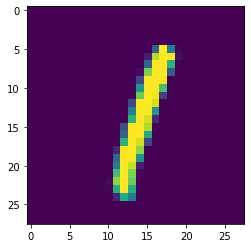

In [285]:
print(model(mod_image.reshape(-1,784)))
plt.imshow(mod_image.view(28,28))

In [253]:
from scipy.stats import bernoulli
def bernoulli_diagonal(mat):
    p=0.5
    r = torch.Tensor(bernoulli.rvs(p, size=mat.shape[1]))
    ind = np.diag_indices(mat.shape[1])
    diag_mat = torch.zeros((mat.shape[1], mat.shape[1]))
    diag_mat[ind[0], ind[1]] = r
    return torch.Tensor(diag_mat)

In [254]:
T = 100
distr = np.zeros((T,10))
label = torch.argmax(model(sample_image.reshape(-1,784))).item()
for t in range(T):
    model_copy = copy.deepcopy(model)
    
    data = model_copy.fc1.weight.data
    diag = bernoulli_diagonal(data)
    dropout_data = torch.matmul(data,diag)
    model_copy.fc1.weight = nn.Parameter(dropout_data)
    
    data = model_copy.fc2.weight.data
    diag = bernoulli_diagonal(data)
    dropout_data = torch.matmul(data,diag)
    model_copy.fc2.weight = nn.Parameter(dropout_data)
    
    data = model_copy.fc3.weight.data
    diag = bernoulli_diagonal(data)
    dropout_data = torch.matmul(data,diag)
    model_copy.fc3.weight = nn.Parameter(dropout_data)
    
    distr[t] = model_copy(sample_image.reshape(-1,784)).detach().numpy()[0]

In [243]:
tau = 10
mean = np.mean(distr,axis=0)
covariance = 1/tau*np.identity(len(mean))
covariance += np.mean(np.array([np.outer(x,x) for x in distr]),axis=0) - np.outer(mean,mean)
std = np.sqrt(covariance.diagonal())

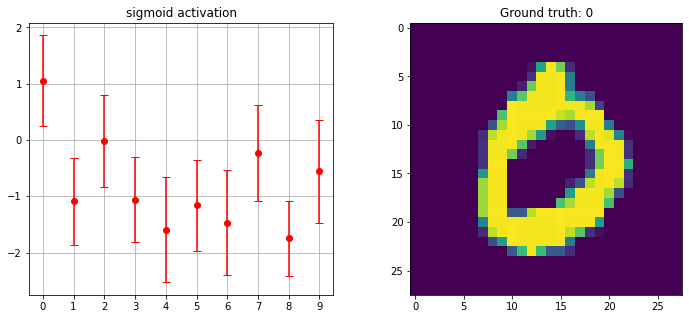

In [244]:
activation = 'sigmoid'
fig = plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.title(activation + ' activation')
plt.errorbar(list(range(10)),mean,yerr=std, fmt='ro', capsize=4)
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.grid('True')

fig.add_subplot(122)
plt.title('Ground truth: {}'.format(sample_label))
plt.imshow(sample_image.view(28,28))
#plt.savefig(activation + ' activation, label {}.png'.format(label))
plt.show()